In [61]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/COVID-19_Radiography_Dataset.zip' .
!unzip -q -n COVID-19_Radiography_Dataset.zip
data_dir ='/content/COVID-19_Radiography_Dataset'



Mounted at /content/drive


ΚΑΤΗΓΟΡΙΕΣ: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
ΣΥΝΟΛΟ ΕΙΚΟΝΩΝ: 21165
Index 19669, Label: 2 (Normal)
Index 13996, Label: 2 (Normal)
Index 6633, Label: 1 (Lung_Opacity)
Index 9437, Label: 1 (Lung_Opacity)
Index 12850, Label: 2 (Normal)
Index 20663, Label: 3 (Viral Pneumonia)
Index 6897, Label: 1 (Lung_Opacity)
Index 20904, Label: 3 (Viral Pneumonia)
Index 20287, Label: 3 (Viral Pneumonia)
Index 8412, Label: 1 (Lung_Opacity)
Index 795, Label: 0 (COVID)
Index 17257, Label: 2 (Normal)
Index 14107, Label: 2 (Normal)
Index 2285, Label: 0 (COVID)
Index 2173, Label: 0 (COVID)
Index 13113, Label: 2 (Normal)
Index 3902, Label: 1 (Lung_Opacity)
Index 12689, Label: 2 (Normal)
Index 899, Label: 0 (COVID)
Index 5559, Label: 1 (Lung_Opacity)
Index 2896, Label: 0 (COVID)
Index 14765, Label: 2 (Normal)
Index 19790, Label: 2 (Normal)
Index 20363, Label: 3 (Viral Pneumonia)
Index 6353, Label: 1 (Lung_Opacity)


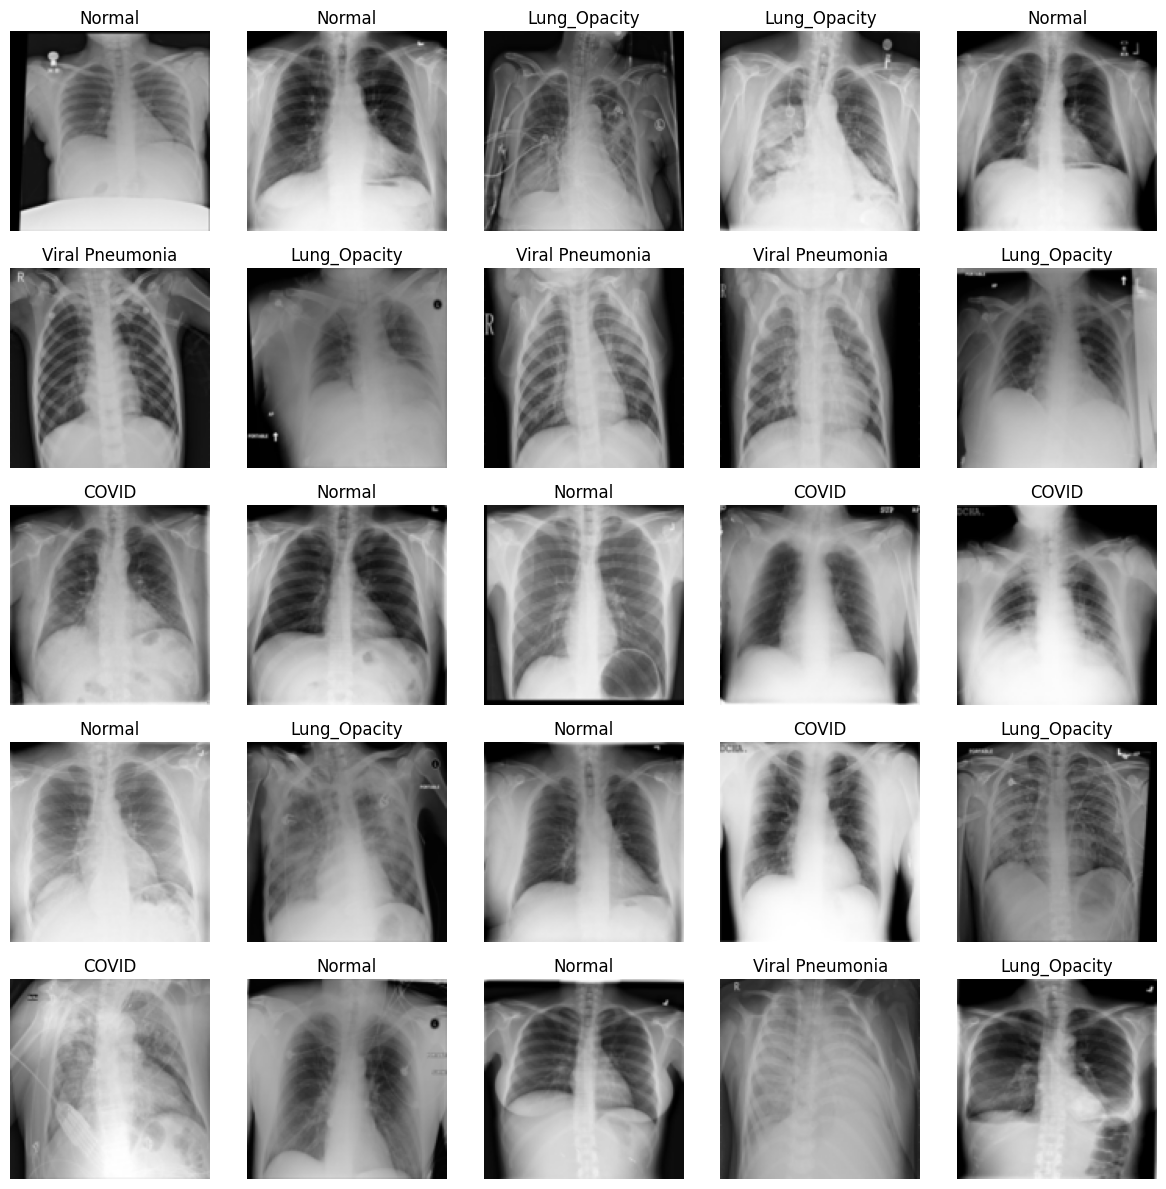

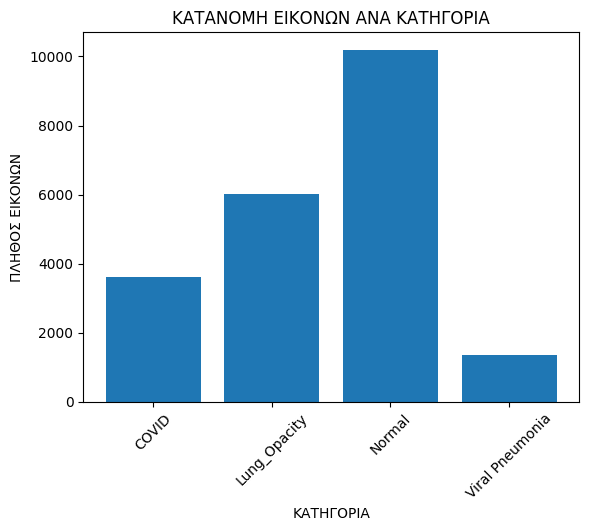

In [62]:

#2.1 Κλάση COVID19Dataset
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from collections import Counter

class COVID19Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """Αρχικοποίηση του dataset με τον δοσμένο κατάλογο root."""
        self.root_dir = root_dir #αποοθηκευουμε τη διαδρομή του ριζικού φακέλου
        self.transform = transform #αποθηκευει τους μετασχηματισμους που γινονται στισ εικόνες αν δοθουν
        self.data = [] #Αρχικοποιείται ως κενή λίστα και θα γεμίσει με ζεύγη δηλάδη με το path και την ετικετα ποθ αντιστοιχει στην κατηγορία της εικόνας
        self.classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

        # Συλλογή δεδομένων και κατηγοριών
        for idx, class_name in enumerate(self.classes): # επαναλαμβανει για καθεκατηγορια (covid//Ιογενής πνευμονία//φυσιολογική//Πνευμονικές αδιαφάνειες)
            class_dir = os.path.join(root_dir, class_name) #δημιουργια της διαδρομής του φακέλου ανάλογα με την κατηγορία
            if os.path.isdir(class_dir): #Ελέγχει αν υπάρχει ο φάκελος για την κατηγορία
                for file_name in os.listdir(class_dir): #επανάληψη για καθε αρχειο στον φαάκελο
                    file_path = os.path.join(class_dir, file_name)#δημιουργία  path
                    if file_name.endswith('.png') or file_name.endswith('.jpg'):# Ελέγχει αν το αρχείο είναι εικόνα (.png ή .jpg).
                        self.data.append((file_path, idx)) #Προσθέτει στη λίστα self.data ένα ζεύγος με το path και τον αριθμό της κατηγορίας

        # Έλεγχος για τις ετικέτες//debugging
        print("ΚΑΤΗΓΟΡΙΕΣ:", self.classes)
        print("ΣΥΝΟΛΟ ΕΙΚΟΝΩΝ:", len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]

        # Έλεγχος εγκυρότητας της ετικέτας
        if label >= len(self.classes):
            raise ValueError(f"Label {label} is out of range for classes. Total classes: {len(self.classes)}")

        # Άνοιγμα εικόνας και μετατροπή της σε RGB
        image = Image.open(img_path).convert("RGB")

        # Εφαρμογή μετασχηματισμών αν υπάρχουν
        if self.transform:
            image = self.transform(image)

        return image, label #επιστρεφουμε το ζεύγος

    def display_batch(self, indexes):
        """Εμφανίζει ένα batch από εικόνες δεδομένων με τις αντίστοιχες ετικέτες τουσ"""
        fig, axes = plt.subplots(5, 5, figsize=(12, 12)) #δημιουργουμε εναν πίνακα από 5 × 5 υποπλαίσια δηκ 25

        for ax, idx in zip(axes.flatten(), indexes): #Συνδυάζει κάθε υποπλαίσιο (άξονα ax) με idx από τη λίστα indexes
            img, label = self.__getitem__(idx)

            # Εκτύπωση της ετικέτας για λ'ογους debugging
            print(f"Index {idx}, Label: {label} ({self.classes[label]})")

            ax.imshow(transforms.ToPILImage()(img))   #Εμφανίζει την εικόνα στο τρέχον υποπλαίσιο και  μετατρέπεται σε μορφή PIL με την χρήση της  transforms.ToPILImage()
            ax.set_title(self.classes[label]) # Ορίζει ως τίτλο του υποπλαισίου του ονοματος της κλάσης που αντιστοιχεί στην συγκεκριμένη ετικέτα
            ax.axis("off")

        # Αν περισσεύουν κενά υποπλαίσια, απενεργοποιήστε τα
        for ax in axes.flatten()[len(indexes):]:
            ax.axis("off")

        plt.tight_layout()  #Προσαρμόζει αυτόματα την απόσταση ανάμεσα στα υποπλαίσια ώστε να μην επικαλύπτονται για μια καθάρη εικόνα
        plt.show()

# Ορισμός των μετασχηματισμών για την επεξεργασία των εικόνων
transformation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Δημιουργία του αντικειμένου του dataset
path = '/content/COVID19Dataset'


DATASET = COVID19Dataset(root_dir=path, transform=transformation)

# Δημιουργία λίστας με 25 τυχαία indexes
randomindx= random.sample(range(len(DATASET)), 25) #χεησιμοποιούμε την  random.sample για να δημιουργηθεί μια λίστα με 25 τυχαίους  indexes από το dataset

# Παρουσίαση 25 τυχαίων εικόνων
DATASET.display_batch(randomindx)

# Υπολογισμός του πλήθους των εικόνων ανά κλάση
classsum = Counter(label for _, label in DATASET.data)# Χρησιμοποιουμε την  Counter από το module collections για να μετρηθεί το πλήθος των εικόνων σε κάθε κατηγορία

# Δημιουργία ραβδογράμματος για την κατανομή των εικόνων ανά κατηγορία
plt.bar(DATASET.classes, [classsum[i] for i in range(len(DATASET.classes))])
plt.xlabel("ΚΑΤΗΓΟΡΙΑ")
plt.ylabel("ΠΛΗΘΟΣ ΕΙΚΟΝΩΝ")
plt.title("ΚΑΤΑΝΟΜΗ ΕΙΚΟΝΩΝ ΑΝΑ ΚΑΤΗΓΟΡΙΑ")
plt.xticks(rotation=45)
plt.show()



In [63]:
#3 Συναρτήσεις εκπαίδευσης και δοκιμής

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from collections import Counter

def confusion_matrix(y, y_pred, num_classes):

    cmatrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)#δημιουργούμε έναν πίνακα cm  με μηδενικά,
    for t, p in zip(y.view(-1), y_pred.view(-1)): #Το zip(y, y_pred) δημιουργεί ζευγάρια όπου:  t είναι η πραγματική κλάση p είναι η προβλεπόμενη κλάση από το μοντελο μας//με view(-1) μετατρεπουμε μετατρέπει τα tensors σε μονοδιάστατους πίνακες
        cmatrix[t.long(), p.long()] += 1 #Μετατρέπουμε τις τιμές t και p σε τύπο long// cm[t,p]+=1 αυξάνουμε κατά 1 την αντίστοιχη θέση του πίνακα
    return cmatrix
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):

    model.train()
    running_loss = 0.0  # Συνολική απώλεια για όλα τα batches
    correct = 0         # Συνολικός αριθμός σωστών προβλέψεων
    total = 0           # Συνολικός αριθμός δειγμάτων

    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # Μηδενισμός των gradients
        optimizer.zero_grad()

        # Εμπρόσθια διάδοση
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Οπισθόδρομη διάδοση και ενημέρωση βαρών
        loss.backward()
        optimizer.step()

        # Ενημέρωση συνολικής απώλειας
        running_loss += loss.item() * images.size(0)

        # Υπολογισμός σωστών προβλέψεων
        _, predicted = torch.max(outputs, 1)  # Λήψη της κατηγορίας με τη μέγιστη πιθανότητα
        correct += (predicted == labels).sum().item()  # Σύγκριση με πραγματικές ετικέτες
        total += labels.size(0)  # Ενημέρωση συνολικού αριθμού δειγμάτων

    # Υπολογισμός μέσης απώλειας και ακρίβειας
    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total

    return avg_loss, accuracy #Υπολογίζουμε τη μέση απώλεια διαιρώντας τη συνολική απώλεια running_loss με τον αριθμό των batches (len(dataloader))

def test(model, dataloader, loss_fn, device, num_classes):

    model.eval()# απενεργοποιουμε  layers  που χρησιμοποιούνται μόνο κατά την εκπαίδευση


#αρχικοποιίηση μεταβλητών
    running_loss = 0.0
    correct = 0 #Κρατά τον αριθμό των σωστών προβλέψεων
    total = 0 # Κρατά το συνολικό αριθμό δειγμάτων
    #Αποθηκεύουμε τις πραγματικές και τις προβλεπόμενες ετικέτες όλων των δειγμάτων
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader: #οdataloader παρέχει τα δεδομένα σε batches επομένως κανουμε επανάληψη για κάθε batches
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Εμπρόσθια διάδοση
            outputs = model(images) # Οι εικόνες περνούν μέσα από το μοντέλο (model) και παράγονται οι προβλέψεις
            #Υπολογίζεται η απώλεια για το συγκεκριμένο batch και προστίθεται στο running_loss
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # Πρόβλεψη ετικετών
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item() #Ελέγχουμε πόσες προβλέψεις είναι σωστές (preds == labels) και τιε προσθέτουμε στο correct
            total += labels.size(0)
            #Αποθηκεύουμε τις πραγματικές  και τις προβλεπόμενες ετικέτες
            all_labels.append(labels)
            all_preds.append(preds)

    # Υπολογισμός πίνακα σύγχυσης
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    cm = confusion_matrix(all_labels, all_preds, num_classes)
    #την τιμή της συνάρτησης απώλειας, την ευστοχία και τον πίνακα σύγχυσης του μοντέλου στο σύνολο δεδομένων που αντιστοιχεί ο DataLoade
    accuracy = correct / total
    return running_loss / len(dataloader), accuracy, cm


ΚΑΤΗΓΟΡΙΕΣ: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
ΣΥΝΟΛΟ ΕΙΚΟΝΩΝ: 21165
Epoch 1/20
Train Loss: 1.1222, Train Accuracy: 51.34%
Val Loss: 1.0010, Val Accuracy: 57.95%
Confusion Matrix:
tensor([[   2,  185,  504,    0],
        [   3,  586,  616,    0],
        [   1,  170, 1865,    0],
        [   1,   87,  213,    0]])
Epoch 2/20
Train Loss: 0.9339, Train Accuracy: 61.52%
Val Loss: 0.8927, Val Accuracy: 63.97%
Confusion Matrix:
tensor([[  69,  193,  428,    1],
        [  61,  741,  402,    1],
        [  46,  202, 1739,   49],
        [  19,   55,   68,  159]])
Epoch 3/20
Train Loss: 0.8628, Train Accuracy: 65.19%
Val Loss: 0.8437, Val Accuracy: 65.49%
Confusion Matrix:
tensor([[  84,  201,  403,    3],
        [  54,  759,  388,    4],
        [  53,  173, 1737,   73],
        [  12,   45,   52,  192]])
Epoch 4/20
Train Loss: 0.8271, Train Accuracy: 66.59%
Val Loss: 0.8194, Val Accuracy: 66.45%
Confusion Matrix:
tensor([[ 102,  192,  395,    2],
        [  56,  759,  

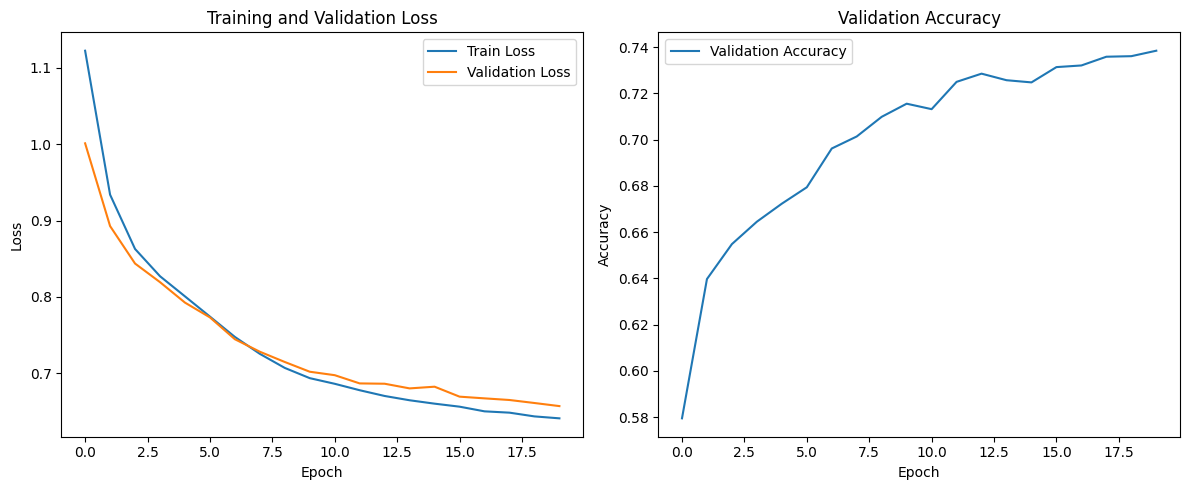

In [64]:
#4 Απλό συνελικτικό δίκτυο CNN1


import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
#from COVID19Dataset import COVID19Dataset
#from ex2 import train_one_epoch, test  # Εισαγωγή έτοιμων συναρτήσεων


# Model definition
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()

        # Συνελικτικά επίπεδα
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)  # 8 φίλτρα 3x3 ΠΡΩΤΟ ΕΠΙΠΕΔΟ
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3) # 16 φίλτρα 3x3 ΔΕΥΤΕΡΟ ΕΠΙΠΕΔΟ

        # Επίπεδα ενεργοποίησης
        self.relu = nn.ReLU() # συνάρτηση ενεργοποίησης ReLU

        # Επίπεδα συγκέντρωσης (max pooling)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #Εφαρμόζει ένα παράθυρο 2×2 kernel size

        # Placeholder για δυναμικό υπολογισμό in_features
        self.fc1 = None # αρχικοποιούμε αρχικά ως None επειδή θα το υπολογίσουμε  έπειτα στο forward()
        self.fc2 = nn.Linear(32, 4)  # To δεύτερο fully connected παραμένει σταθερό//4 εξόδους  για κάθε κατηγορία ταξινόμησης

    def forward(self, x):
        # Επίπεδο 1: Conv + ReLU + Pooling
        x = self.conv1(x)    # Conv1
        x = self.relu(x)     # ReLU1
        x = self.pool(x)     # Pooling1

        # Επίπεδο 2: Conv + ReLU + Pooling
        x = self.conv2(x)    # Conv2
        x = self.relu(x)     # ReLU2
        x = self.pool(x)     # Pooling2

        # Επίπεδο μετατροπής σε 1 διάσταση
        x = x.view(x.size(0), -1)  # Flatten

        # Υπολογισμός του fully connected μόνο την πρώτη φορά
        if self.fc1 is None:
            in_features = x.size(1)
            self.fc1 = nn.Linear(in_features, 32).to(x.device)  # Δυναμική δημιουργία του fc1

        # Πλήρως συνδεδεμένα επίπεδα
        x = self.fc1(x)      # Fully Connected 1
        x = self.relu(x)     # ReLU3
        x = self.fc2(x)      # Fully Connected 2
        return x


# Μετασχηματισμοί εικόνων
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Μετατροπή σε grayscale (1 κανάλι )
    transforms.Resize((28, 28)),                 # Αλλαγή μεγέθους σε 28x28
    transforms.ToTensor(),                       # Μετατροπή σε tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Κανονικοποίηση (0, 1)
])

# Δημιουργία αντικειμένου COVID19Dataset
data = COVID19Dataset(root_dir='/content/COVID19Dataset', transform=transform)

# Διαχωρισμός σε σύνολα εκπαίδευσης, επικύρωσης και δοκιμής
generator = torch.Generator().manual_seed(42)#τυχαίοσ αριθμός αρχικοποίησηςγια αναπαραγωγή των αποτελεσμάτων
train_ds, val_ds, test_ds = random_split(data, [0.6, 0.2, 0.2], generator=generator)# 60% για εκπαίδευση (train)//20% για επικύρωση (val)//20% για δοκιμή (test)

# Δημιουργία DataLoaders
trainloader = DataLoader(train_ds, batch_size=64, shuffle=True)

#για επικύρωση και δοκιμή διατηρoύμε  τη σειρά των δεδομένων αρα shuffle=False
valloader = DataLoader(val_ds, batch_size=64, shuffle=False)
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Ρυθμίσεις συσκευής
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Αρχικοποίηση του μοντέλου, του optimizer και της συνάρτησης απώλειας
model = CNN1().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))  # με β1=0.9, β2=0.99
lossfn = nn.CrossEntropyLoss()
 #Εκπαίδευση με early stopping και αποθήκευση του καλύτερου μοντέλου
num_epochs = 20
num_classes = 4#4 κατηγορίες
best_val_loss = float('inf')
early_stop_counter = 0
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, trainloader, optimizer, lossfn, device)
    val_loss, val_accuracy, val_cm = test(model, valloader, lossfn, device, num_classes)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{val_cm}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "bestmodel.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 5:
            print("Early stopping ")
            break

# Φόρτωση του καλύτερου μοντέλου
model.load_state_dict(torch.load("bestmodel.pth"))

# Τελική αξιολόγηση στο σύνολο δοκιμής
test_loss, test_accuracy, test_cm = test(model, testloader, lossfn, device, num_classes)
print("\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{test_cm}")

# Σχεδίαση γραφημάτων
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.tight_layout()
plt.show()

ΚΑΤΗΓΟΡΙΕΣ: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
ΣΥΝΟΛΟ ΕΙΚΟΝΩΝ: 21165
Epoch 1/20
Train Loss: 1.1628, Train Accuracy: 49.33%
Val Loss: 0.9899, Val Accuracy: 57.36%
Confusion Matrix:
tensor([[  28,  269,  390,    4],
        [   5,  711,  484,    5],
        [  12,  414, 1507,  103],
        [   0,    6,  113,  182]])
Epoch 2/20
Train Loss: 0.8496, Train Accuracy: 64.22%
Val Loss: 0.7467, Val Accuracy: 69.90%
Confusion Matrix:
tensor([[ 114,  144,  432,    1],
        [  44,  709,  445,    7],
        [  24,   56, 1940,   16],
        [   7,   33,   65,  196]])
Epoch 3/20
Train Loss: 0.6539, Train Accuracy: 74.05%
Val Loss: 0.6120, Val Accuracy: 75.62%
Confusion Matrix:
tensor([[ 404,  111,  176,    0],
        [ 150,  840,  214,    1],
        [ 170,  113, 1746,    7],
        [  11,   32,   47,  211]])
Epoch 4/20
Train Loss: 0.5552, Train Accuracy: 78.31%
Val Loss: 0.5345, Val Accuracy: 79.33%
Confusion Matrix:
tensor([[ 529,   41,  115,    6],
        [ 196,  752,  

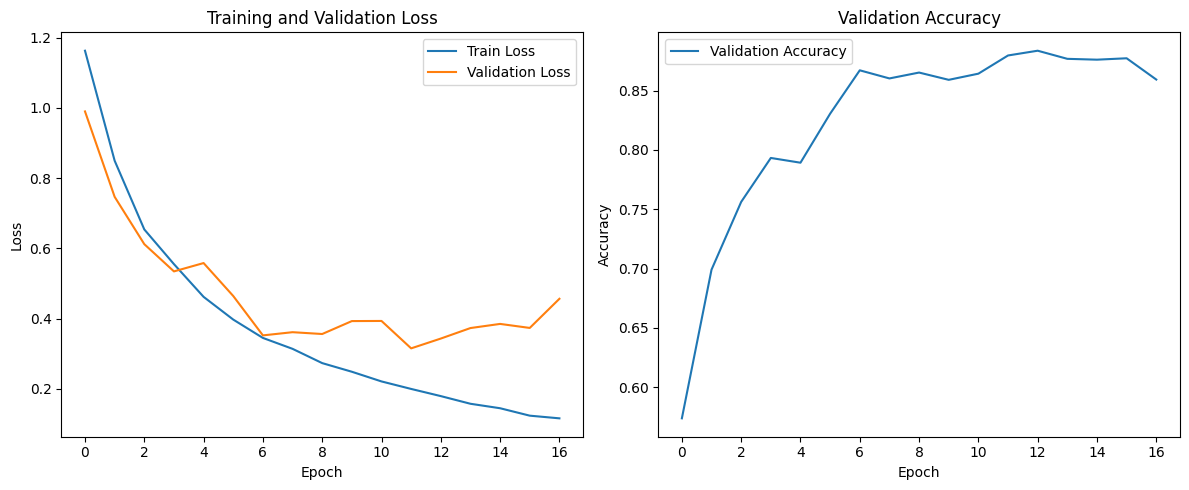

In [65]:

#5 Συνελικτικό δίκτυο μεγαλύτερου βάθους CNN2


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
#from COVID19Dataset import COVID19Dataset
#from ex2 import train_one_epoch, test  # Εισαγωγή έτοιμων συναρτήσεων


class CNN2(nn.Module):
    def __init__(self, num_classes):
        super(CNN2, self).__init__()

# Επίπεδο 1: 2 διαδοχικά συνελικτικά επίπεδα με 32 φίλτρα 3x3 και ReLU        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # χρησιμοποιούμε padding=1 είναι για να διατηρήσουμε τις διαστάσεις του εισερχόμενου πίνακα  ίδιες με αυτές της εξόδου του συνελικτικού επιπέδου έτσι το χρησιμοποιώ παρακάτω
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

               # Επίπεδο Max Pooling με βήμα 4
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Max Pooling Layer με βήμα 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

       # Επίπεδο 3: 2 διαδοχικά συνελικτικά επίπεδα με 128 φίλτρα 3x3 και ReLU
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)


# Max Pooling Layer με βήμα 2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Επίπεδο 4: 3 διαδοχικά συνελικτικά επίπεδα με 256 φίλτρα 3x3 και ReLU
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # Max Pooling Layer με βήμα 2
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Επίπεδο 5: 1 συνελικτικό επίπεδο με 512 φίλτρα 3x3 και ReLU
        self.conv10 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)

        # Max Pooling Layer με βήμα 2
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Πλήρως συνδεδεμένα επίπεδα
        self.fc1 = None  # Θα το ορίσουμε δυναμικά
        self.fc_relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, num_classes)  # Θα προσαρμοστεί δυναμικά η fc1

    def forward(self, x):
    # Επεξεργασία μέσω των επιπέδων συνελικτικών, ReLU και Max Pooling με τη σειρά που ορίζονται
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.relu(x)
        x = self.conv9(x)
        x = self.relu(x)
        x = self.pool4(x)

        x = self.conv10(x)
        x = self.relu(x)
        x = self.pool5(x)

    # Δυναμικός υπολογισμός του πλήρως συνδεδεμένου επιπέδου fc1 βάσει των διαστάσεων της εξόδου
        if self.fc1 is None:
         self.fc1 = nn.Linear(x.view(x.size(0), -1).size(1), 1024).to(x.device) #   Υπολογισμός του αριθμού των εισόδων του fc1 αφού κάνουμε flatten το x

        #  Μετατροπή της εξόδου σε μονοδιάστατο πίνακα για είσοδο στο πλήρως συνδεδεμένο επίπεδο
        x = x.view(x.size(0), -1) ## Flatten μετατροπή σε 1 διάσταση)

            # Επεξεργασία μέσω των πλήρως συνδεδεμένων επιπέδων
        x = self.fc1(x)
        x = self.fc_relu(x)
        x = self.fc2(x)

        return x



# Ρυθμίσεις συσκευής
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Μετασχηματισμοί εικόνων
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Μετατροπή σε grayscale (1 κανάλι )
    transforms.Resize((128, 128)),  ## Αλλαγή μεγέθους σε  128x128
    transforms.ToTensor()  # Μετατροπή σε tensor
])

# Δημιουργία αντικειμένου COVID19Dataset

#path = "/home/eirini/Downloads/ΜΗΧΑΝΙΚΗ ΜΑΘΗΣΗ/COVID19Dataset"
DATASET = COVID19Dataset(root_dir= '/content/COVID19Dataset', transform=transformation)

# Split dataset
generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(DATASET, [0.6, 0.2, 0.2], generator=generator)


# Δημιουργία DataLoaders
trainloader = DataLoader(train_ds, batch_size=64, shuffle=True)

#για επικύρωση και δοκιμή διατηρoύμε  τη σειρά των δεδομένων αρα shuffle=False

valloader = DataLoader(val_ds, batch_size=64, shuffle=False)
testloader = DataLoader(test_ds, batch_size=64, shuffle=False)

# Αρχικοποίηση του μοντέλου, του optimizer και της συνάρτησης απώλειας
num_classes = len(DATASET.classes)
model = CNN2(num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
lossfn = nn.CrossEntropyLoss()

 #Εκπαίδευση με early stopping και αποθήκευση του καλύτερου μοντέλου

num_epochs = 20
best_val_loss = float('inf')
early_stop_counter = 0

train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_accuracy = train_one_epoch(model, trainloader, optimizer, lossfn, device)
    val_loss, val_accuracy, val_cm = test(model, valloader, lossfn, device, num_classes)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{val_cm}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_cnn2_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 5:
            print("Early stopping triggered.")
            break

# Φόρτωση του καλύτερου μοντέλου
model.load_state_dict(torch.load("best_cnn2_model.pth"))
test_loss, test_accuracy, test_cm = test(model, testloader, lossfn, device, num_classes)


# Τελική αξιολόγηση στο σύνολο δοκιμής

print("\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{test_cm}")

# Σχεδίαση γραφημάτων
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.tight_layout()
plt.show()


ΚΑΤΗΓΟΡΙΕΣ: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
ΣΥΝΟΛΟ ΕΙΚΟΝΩΝ: 21165


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


Epoch 1/5
Train Loss: 0.2539, Train Accuracy: 91.04%
Val Loss: 0.1645, Val Accuracy: 94.33%
Confusion Matrix:
tensor([[ 673,    6,   11,    1],
        [  12, 1096,   97,    0],
        [   2,   89, 1938,    7],
        [   2,    0,   13,  286]])
Epoch 2/5
Train Loss: 0.1116, Train Accuracy: 96.18%
Val Loss: 0.1580, Val Accuracy: 94.31%
Confusion Matrix:
tensor([[ 683,    3,    4,    1],
        [  23, 1034,  148,    0],
        [   8,   35, 1988,    5],
        [   3,    0,   11,  287]])
Epoch 3/5
Train Loss: 0.0654, Train Accuracy: 97.64%
Val Loss: 0.1797, Val Accuracy: 94.45%
Confusion Matrix:
tensor([[ 666,   10,   14,    1],
        [   8, 1110,   87,    0],
        [   2,  100, 1928,    6],
        [   0,    0,    7,  294]])
Epoch 4/5
Train Loss: 0.0389, Train Accuracy: 98.58%
Val Loss: 0.2439, Val Accuracy: 94.19%
Confusion Matrix:
tensor([[ 683,    4,    4,    0],
        [  17, 1041,  146,    1],
        [   2,   54, 1972,    8],
        [   4,    0,    6,  291]])
Epoch 5/5
Tr

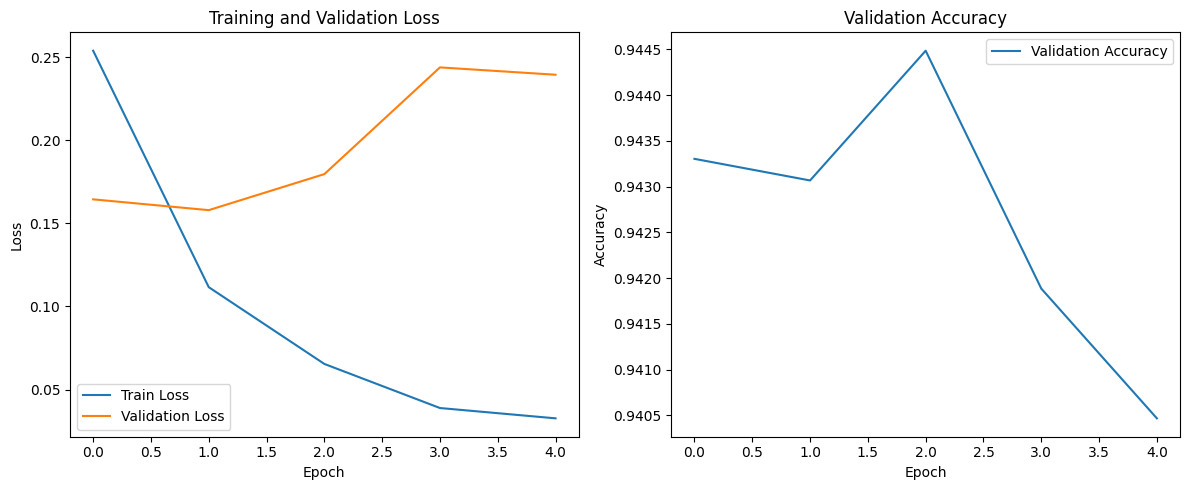

Epoch 1/5 (Feature Extractor)
Train Loss: 0.0520, Train Accuracy: 98.39%
Val Loss: 0.1512, Val Accuracy: 94.76%
Confusion Matrix:
tensor([[ 672,    5,   13,    1],
        [   8, 1064,  133,    0],
        [   1,   45, 1984,    6],
        [   0,    0,   10,  291]])
Epoch 2/5 (Feature Extractor)
Train Loss: 0.0448, Train Accuracy: 98.54%
Val Loss: 0.1560, Val Accuracy: 94.92%
Confusion Matrix:
tensor([[ 669,    7,   14,    1],
        [   8, 1077,  120,    0],
        [   1,   49, 1980,    6],
        [   0,    0,    9,  292]])
Epoch 3/5 (Feature Extractor)
Train Loss: 0.0411, Train Accuracy: 98.58%
Val Loss: 0.1598, Val Accuracy: 95.02%
Confusion Matrix:
tensor([[ 680,    4,    6,    1],
        [  13, 1079,  113,    0],
        [   5,   55, 1970,    6],
        [   0,    0,    8,  293]])
Epoch 4/5 (Feature Extractor)
Train Loss: 0.0408, Train Accuracy: 98.69%
Val Loss: 0.1609, Val Accuracy: 94.99%
Confusion Matrix:
tensor([[ 673,    8,    9,    1],
        [   8, 1098,   99,    0],
 

In [66]:
#6 Με χρήση προεκπαιδευμένου δικτύου

import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
#from COVID19Dataset import COVID19Dataset
#from ex2 import train_one_epoch, test  # Εισαγωγή έτοιμων συναρτήσεων
from torchvision import models
import gc

# Μετασχηματισμοί εικόνων
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Αλλαγή σε 3 κανάλια (απαιτείται για ResNet)
    transforms.Resize((224, 224)),               # Αλλαγή μεγέθους σε 224x224 (ResNet απαιτεί αυτή τη διάσταση)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Κανονικοποίηση
])

# Δημιουργία αντικειμένου COVID19Dataset
DATASET = COVID19Dataset(root_dir='/content/COVID19Dataset', transform=transformation)

generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = \
random_split(DATASET, [0.6, 0.2, 0.2], generator=generator)#    Training set (60%)// Validation set (20%)// Test set (20%).



# Δημιουργία dataLoaders με batch_size=64
trainloader = DataLoader(train_ds, batch_size=64, shuffle=True)
valloader = DataLoader(val_ds, batch_size=64, shuffle=False)
testloader = DataLoader(test_ds, batch_size=64, shuffle=False)

# Ρυθμίσεις συσκευής
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Φόρτωση προεκπαιδευμένου ResNet50
resnet50 = models.resnet50(pretrained=True)

# Τελικό επίπεδο ταξινόμησης
num_classes = len(DATASET.classes)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Μεταφορά στη συσκευή
resnet50 = resnet50.to(device)

# Υπερπαράμετροι//Ρυθμός μάθησης (lr): 0.0001//Optimizer: Adam.
lr = 1e-4
epochs = 5
optimizer = optim.Adam(resnet50.parameters(), lr=lr, betas=(0.9, 0.99))
lossfn = nn.CrossEntropyLoss()

# Εκπαίδευση
train_losses, val_losses, val_accuracies = [], [], []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    resnet50.train()
    train_loss, train_accuracy = train_one_epoch(resnet50, trainloader, optimizer, lossfn, device)
    val_loss, val_accuracy, val_cm = test(resnet50, valloader, lossfn, device, num_classes)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{val_cm}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
#Early stoppingg
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(resnet50.state_dict(), "best_resnet50.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 5:
            print("Early stopping triggered.") #Σταματάει η εκπαίδευση αν δεν βελτιωθεί για 5 εποχές.
            break
    torch.cuda.empty_cache()
    gc.collect()
# Φόρτωση του καλύτερου μοντέλου
resnet50.load_state_dict(torch.load("best_resnet50.pth"))

# Τελική αξιολόγηση
test_loss, test_accuracy, test_cm = test(resnet50, testloader, lossfn, device, num_classes)
print("\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{test_cm}")

# Σχεδίαση γραφημάτων για debugging
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.tight_layout()
plt.show()

# Χρήση ResNet ως εξαγωγέας χαρακτηριστικώ

# Πάγωμα των συνελικτικών επιπέδων
for param in resnet50.parameters():
    param.requires_grad = False

# Αποπάγωμα του τελικού πλήρως συνδεδεμένου επιπέδου
for param in resnet50.fc.parameters():
    param.requires_grad = True

# Επανεκπαίδευση μόνο του τελικού επιπέδου για πειραματισμό
optimizer = optim.Adam(resnet50.fc.parameters(), lr=lr)

# Επαναλαμβάνουμε την ίδια εκπαίδευση με μόνο το τελευταίο επίπεδο εκπαιδεύσιμο
train_losses, val_losses, val_accuracies = [], [], []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    resnet50.train()
    train_loss, train_accuracy = train_one_epoch(resnet50, trainloader, optimizer, lossfn, device)
    val_loss, val_accuracy, val_cm = test(resnet50, valloader, lossfn, device, num_classes)

    print(f"Epoch {epoch + 1}/{epochs} (Feature Extractor)")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{val_cm}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(resnet50.state_dict(), "best_resnet50_feature_extractor.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 5:
            print("Early stopping triggered.")
            break
    torch.cuda.empty_cache()
    gc.collect()
# Φόρτωση του καλύτερου μοντέλου ως εξαγωγέα χαρακτηριστικών
resnet50.load_state_dict(torch.load("best_resnet50_feature_extractor.pth"))

# Αξιολόγηση στο test set
test_loss, test_accuracy, test_cm = test(resnet50, testloader, lossfn, device, num_classes)
print("\nFinal Test Results (Feature Extractor):")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{test_cm}")


ΚΑΤΗΓΟΡΙΕΣ: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
ΣΥΝΟΛΟ ΕΙΚΟΝΩΝ: 21165
Epoch 1/5
Train Loss: 0.7381, Train Accuracy: 71.47%
Val Loss: 0.9809, Val Accuracy: 65.67%
Confusion Matrix:
tensor([[ 209,   26,  454,    2],
        [   6,  471,  728,    0],
        [  21,   39, 1929,   47],
        [  29,    3,   98,  171]])
Epoch 2/5
Train Loss: 0.5159, Train Accuracy: 81.14%
Val Loss: 0.6298, Val Accuracy: 75.88%
Confusion Matrix:
tensor([[ 625,   32,   16,   18],
        [ 110,  956,  115,   24],
        [ 231,  260, 1346,  199],
        [  16,    0,    0,  285]])
Epoch 3/5
Train Loss: 0.4033, Train Accuracy: 85.52%
Val Loss: 1.0420, Val Accuracy: 65.58%
Confusion Matrix:
tensor([[ 551,    4,  136,    0],
        [ 261,  498,  446,    0],
        [ 353,   17, 1666,    0],
        [ 185,    1,   54,   61]])
Epoch 4/5
Train Loss: 0.3464, Train Accuracy: 87.57%
Val Loss: 0.4547, Val Accuracy: 83.68%
Confusion Matrix:
tensor([[ 399,   87,  178,   27],
        [   2,  977,  226,

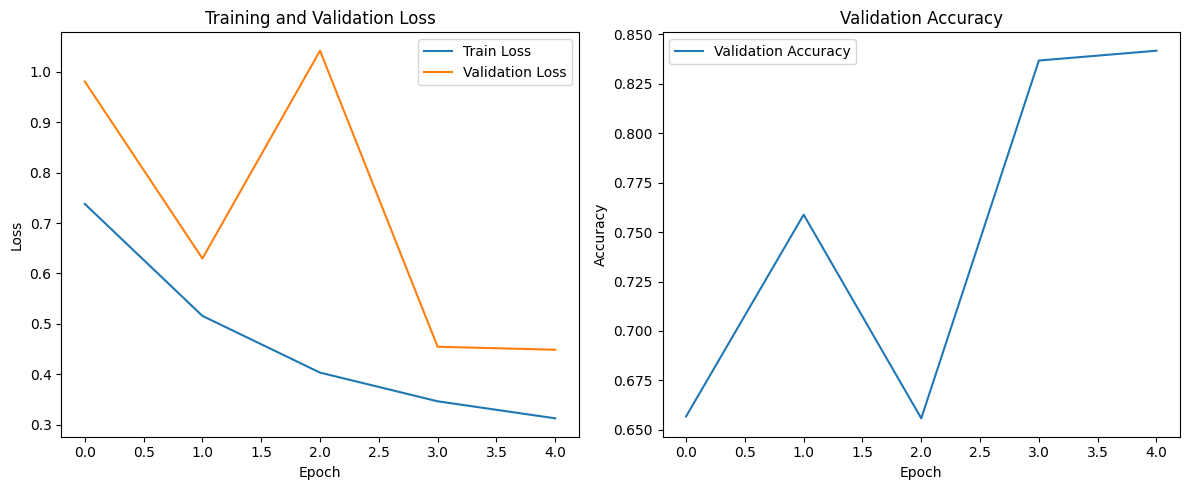

In [67]:
#7.Συνελικτικό δίκτυο με παραλειπόμενες συνδέσεις


import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
# from COVID19Dataset import COVID19Dataset
# from ex2 import train_one_epoch, tes

# Συναρτήσεις μετασχηματισμού δεδομένων
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Αλλαγή σε 3 κανάλια
    transforms.Resize((224, 224)),               # Αλλαγή μεγέθους εικόνας
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Κανονικοποίηση
])

# Δημιουργία του dataset
DATASET = COVID19Dataset(root_dir='/content/COVID19Dataset', transform=transformation)

# Διαχωρισμός του dataset σε training, validation και test σύμφωνα και με τισ προηγούμενες υλοποιησεισ
generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(DATASET, [0.6, 0.2, 0.2], generator=generator)

# Δημιουργία dataLoaders
trainloader = DataLoader(train_ds, batch_size=64, shuffle=True)
valloader = DataLoader(val_ds, batch_size=64, shuffle=False)
testloader = DataLoader(test_ds, batch_size=64, shuffle=False)

# Ρύθμιση συσκευής
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Επίπεδο 1( 2 διαδοχικά συνελικτικά επίπεδα με 32 φίλτρα 3x3 και ReLU)
class BasicBlock(nn.Module):
    def __init__(self, n_in, n_filters, stride=1):
        super(BasicBlock, self).__init__()
        #Το padding το χρησιμοποιούμε για να εξασφαλίσει ότι οι διαστάσεις εξόδου παραμένουν οι ίδιες εάν το stride είναι 1//bias=False: Το bias το παραλείπουμε καθώς θα χρησιμοποιηθεί κανονικοποίηση
        self.conv1 = nn.Conv2d(n_in, n_filters, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(n_filters)


        #Αυτό εξασφαλίζει ότι η είσοδος  μπορεί να προστεθεί στην έξοδο  ακόμα και αν έχουν διαφορετικές διαστάσεις
        self.downsample = None
        if stride != 1 or n_in != n_filters:
            self.downsample = nn.Sequential(
                nn.Conv2d(n_in, n_filters, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(n_filters)
            )

    def forward(self, x):
        identity = x  # Διατηρούμε την αρχική είσοδο

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Αν υπάρχει downsample, εφαρμόζεται στην είσοδο
        if self.downsample is not None:
            identity = self.downsample(x) #Η αρχική identity προστίθεται στην έξοδο της δεύτερης συνελικτικής στρώσης

        out += identity  # Πρόσθεση με την είσοδο
        out = self.relu(out)

        return out


# Δημιουργία του μοντέλου
class ChestXRayModel(nn.Module):
    def __init__(self, num_classes):
        super(ChestXRayModel, self).__init__()

        self.layer1 = BasicBlock(3, 64, stride=1)
        self.layer2 = BasicBlock(64, 128, stride=2)
        self.layer3 = BasicBlock(128, 256, stride=2)
        self.layer4 = BasicBlock(256, 512, stride=2)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = nn.functional.avg_pool2d(x, kernel_size=x.size()[2:])  # Adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)

        return x

# Αριθμός κατηγοριών
num_classes = len(DATASET.classes)

# Δημιουργία μοντέλου
model = ChestXRayModel(num_classes=num_classes).to(device)

# Υπερπαράμετροι
lr = 1e-4
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99)) #όπως και στα πρηγούμενα ερωτήματα
lossfn = nn.CrossEntropyLoss()

# Εκπαίδευση
train_losses, val_losses, val_accuracies = [], [], []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss, train_accuracy = train_one_epoch(model, trainloader, optimizer, lossfn, device)
    val_loss, val_accuracy, val_cm = test(model, valloader, lossfn, device, num_classes)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{val_cm}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    #προσθέτουμε και εδω early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_cnn2_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 5:
            print("Early stopping triggered.")
            break

# Φόρτωση του καλύτερου μοντέλου
model.load_state_dict(torch.load("best_cnn2_model.pth"))
test_loss, test_accuracy, test_cm = test(model, testloader, lossfn, device, num_classes)

# Τελική αξιολόγηση στο σύνολο δοκιμής
print("\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{test_cm}")

# Σχεδίαση γραφημάτωνν
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.tight_layout()
plt.show()

